**Practical NLP** *Lezione1 1*  


# **Trading Stocks Based on Financial News**




---

Unsupervised sentiment analysis using NLTK & Vader

---




# Librerie Utili




*   **Web Scraping:** BeautifulSoup, urllib3
*   **Data Analysis:** Pandas
*   **Data Analysis:** Matplotlib
*   **Language Analysis /& Manipulation:** Natural Language Toolkit (NLTK)



In [2]:
!pip install beautifulsoup4
!pip install urllib3
!pip install pandas
!pip install matplotlib
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import datetime
import numpy as np
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Scraping Notizie Finanziarie

In [23]:

finwiz_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}
tickers = ['META','NVDA', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url='https://finviz.com/quote.ashx?t='+ticker+'&p=d',headers={'User-Agent': 'Mozilla/5.0'}) 
    response = urlopen(req)    
    # lettura contenuto html
    html = BeautifulSoup(response)
    # selezione sezione 'news-table'
    news_table = html.find(id='news-table')
    # salvataggio sezione 'news-table'
    news_tables[ticker] = news_table

## Visualizzazione Esmpio

In [29]:

# Lettura articoli con headline AMAZON 'AMZN' 
amzn = news_tables['META']
# Prende tutte le righe in HTML con <tr> in 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # legge l'elemento 'a' in 'link_text'
    a_text = table_row.a.text
    # legge l'elemento 'td' in 'data_text'
    td_text = table_row.td.text
    # stampa 'link_text' e 'data_text' 
    print(a_text)
    print(td_text)
    print('-----------------------------')
    # stampa solo i primi 4
    if i == 4:
        break

NC investigating claims Facebook received WakeMed, Duke Health patient data
Oct-20-22 08:39AM
-----------------------------
What Do Nvidia, Meta Platforms, and Oracle Have in Common?
Oct-19-22 08:05PM
-----------------------------
What's Going on With Meta Platforms Stock?
07:45PM
-----------------------------
Meta's key deal maker is leaving after more than a decade
05:22PM
-----------------------------
Why Meta Platforms Stock Was Outperforming the Market Today
02:48PM
-----------------------------


## costruzione dataframe 

***Cosa è un DataFrame***

Struttura dati di dimensioni variabili e potenzialmente eterogenea.

La struttura dei dati contiene anche assi etichettati (righe e colonne).

Può essere pensato come un contenitore simile a un dettato per oggetti Serie. 

Il DataFrame è la struttura dati primaria di Pandas.

In [30]:

parsed_news = []

# itera su tutte le news
for file_name, news_table in news_tables.items():
    # itera su tutti i tag tr che sono in 'news_table'
    for x in news_table.findAll('tr'):
        try:
          # legge il testo per ogni tag tr 
          text = x.a.get_text() 
          # splitta il testo per tag td in una lista 
          date_scrape = x.td.text.split()
          # controllo se la lunghezza è 1 altrimenti itera
          if len(date_scrape) == 1:
              time = date_scrape[0] 
          else:
              date = date_scrape[0]
              time = date_scrape[1]
          # estrae l'etichetta del titolo
          ticker = file_name.split('_')[0]
          # append le informazioni alla riga
          parsed_news.append([ticker, date, time, text])
        except:
          pass
        
#parsed_news

# nomi delle colonne
columns = ['ticker', 'date', 'time', 'headline']

# costruzione del dataframe usando pandas
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)


# Sentiment

Verrà svolta in modo non supervisionato usando la libreria NLTK.

***SentimentIntensityAnalyzer()*** Molto simile al concetto di dizionario dove ad ogni termine viene associato un valore di 'polarità'


In [31]:
# scarico la libreria 
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [32]:
# istanzio il sentiment analyzer
vader = SentimentIntensityAnalyzer()


# applico vader ottenedo le polarità delle news
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# mette le polarità come colonna del dataframe
scores_df = pd.DataFrame(scores)
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# converto le date in formato datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date


In [33]:
# mostro i primi x elementi del DataFrame
parsed_and_scored_news.head()

#parsed_and_scored_news.iloc[4].headline

,ticker,date,time,headline,neg,neu,pos,compound
0,META,2022-10-20,08:39AM,NC investigating claims Facebook received Wake...,0.0,1.0,0.0,0.0
1,META,2022-10-19,08:05PM,"What Do Nvidia, Meta Platforms, and Oracle Hav...",0.0,1.0,0.0,0.0
2,META,2022-10-19,07:45PM,What's Going on With Meta Platforms Stock?,0.0,1.0,0.0,0.0
3,META,2022-10-19,05:22PM,Meta's key deal maker is leaving after more th...,0.0,1.0,0.0,0.0
4,META,2022-10-19,02:48PM,Why Meta Platforms Stock Was Outperforming the...,0.0,1.0,0.0,0.0


## Visualizzazione Sentiment

Usando Pandas e Matplotlib visualizziamo la polarità delle notizie estratte.

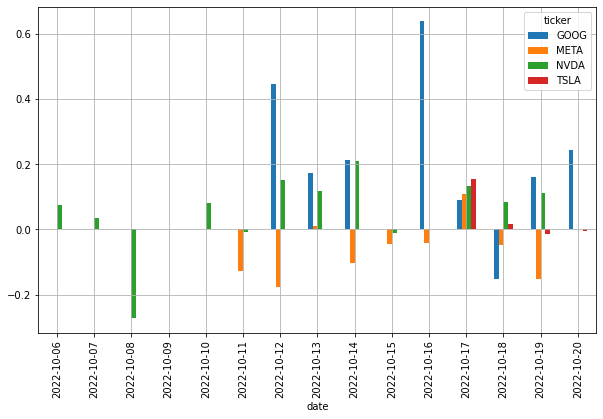

In [34]:
plt.rcParams['figure.figsize'] = [10, 6]

# Raggruppa per data e colonne e calcola la media
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

mean_scores = mean_scores.unstack()

mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

## Altri strumenti per la sentiment analysis

Non esiste solo la libreria NLTK. 

Ci sono altri strumenti come ad esempio TextBlob.

In [35]:
from textblob import TextBlob

def get_polarity(text):
  return TextBlob(text).sentiment.polarity

parsed_and_scored_news['Polarity_TB'] = parsed_and_scored_news['headline'].apply(get_polarity)

In [37]:
get_polarity('God, it was a shitty day.')

Sentiment(polarity=0.0, subjectivity=0.0)

In [56]:
def get_polarity(text):
  return TextBlob(text).sentiment

get_polarity("Meta's key deal maker is leaving after more than a decade")


Sentiment(polarity=0.25, subjectivity=0.75)

In [58]:
get_polarity("Meta announces: 'with inflation it will increase the salaries of its employees'.")

Sentiment(polarity=0.0, subjectivity=0.0)

In [59]:
get_polarity("Mining has become illegal in the US.")

Sentiment(polarity=-0.5, subjectivity=0.5)

In [60]:
parsed_and_scored_news['Sentiment_Type']=''
parsed_and_scored_news.loc[parsed_and_scored_news.Polarity_TB>0,'Sentiment_Type']='POSITIVE'
parsed_and_scored_news.loc[parsed_and_scored_news.Polarity_TB==0,'Sentiment_Type']='NEUTRAL'
parsed_and_scored_news.loc[parsed_and_scored_news.Polarity_TB<0,'Sentiment_Type']='NEGATIVE'

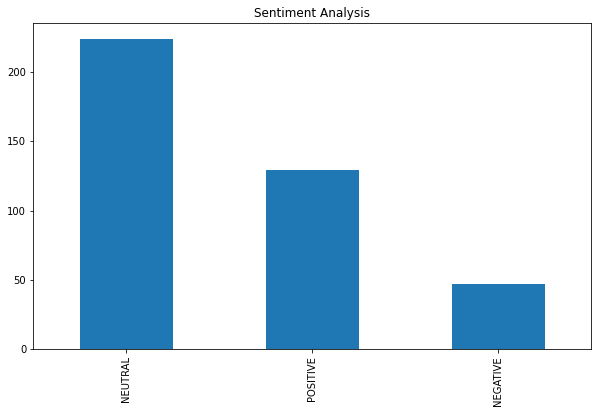

In [61]:
parsed_and_scored_news.Sentiment_Type.value_counts().plot(kind='bar',title="Sentiment Analysis")


In [62]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [63]:
parsed_and_scored_news['Polarity_vader'] = parsed_and_scored_news['headline'].apply(lambda Description: sid.polarity_scores(Description))

parsed_and_scored_news['sentiment_type']=''
parsed_and_scored_news.loc[parsed_and_scored_news.compound>0,'sentiment_type']='POSITIVE'
parsed_and_scored_news.loc[parsed_and_scored_news.compound==0,'sentiment_type']='NEUTRAL'
parsed_and_scored_news.loc[parsed_and_scored_news.compound<0,'sentiment_type']='NEGATIVE'

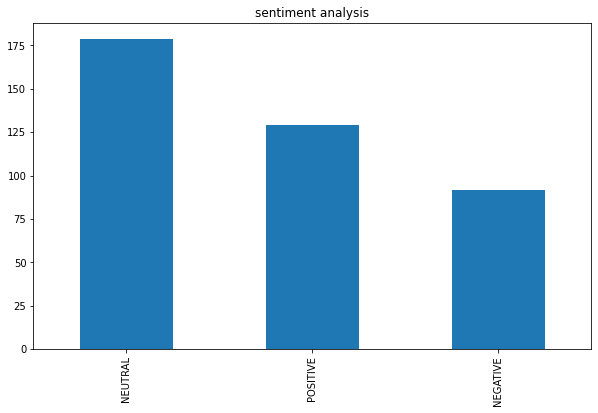

In [64]:
parsed_and_scored_news.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")


In [74]:
s = parsed_and_scored_news['headline'].values.tolist()


In [75]:
type(s)

list